# $\kappa$(ET)$_2$-X の強束縛模型でのバンド計算

$\kappa$(ET)$_2$-X を強束縛模型で計算する。
この結晶は2次元的に扱うことができ、単位胞は$x$軸の格子定数を$a$, $y$軸の格子定数を$b$とした長方形である。

この系のハミルトニアンは2次元ハバード模型

$$
\mathcal{H} = \sum_{ij}t_{ij}(c_i^{\dagger}c_j+\text{h.c.})+U\sum_i n_{\uparrow} n_{\downarrow}
$$
をもとにしたものを使う。この和の添え字はサイトを表している。
これを$\kappa$型の格子に応用したのが
$$
    \mathcal{H}_{\kappa} 
    = U \sum_{i\mu} n_{i\mu\uparrow}n_{i\mu\downarrow}
    + t_a\sum_{i\sigma}(c_{ia\sigma}^\dagger c_{ib\sigma} + \text{h.c})
    +\sum_{\langle ij \rangle \mu\mu'\sigma} 
        t_{ij}^{\mu\mu'}(c_{i\mu\sigma}^\dagger c_{j\mu'\sigma} +\text{h.c.})
$$
である。

ここでの添え字は
 i 番目のダイマー にある
$ \sigma = \uparrow, \downarrow $(スピン), 
$\mu = a,b $(分子内のサイト)
といった意味である。

すると第二項はダイマー内のホッピングを表していて、



ここでのパラメータは

https://doi.org/10.1038/s41467-019-12229-y

を参考にすると

$$
\begin{align*}
    t_{a} &= -0.207 \,\text{eV}\\
    t_{p} &= -0.102 \,\text{eV}\\
    t_{q} &= -0.043 \,\text{eV}\\
    t_{b} &= -0.067 \,\text{eV}\\
    U     &= 1      \,\text{eV}
\end{align*}
$$

というようにすればよいようである。


簡単のため長方形ではなく格子定数が 1 正方形として計算する。

ただ、これはもとのハバードハミルトニアンのホッピングを丁寧に書き下しただけのように見える。
これは平均場ハミルトニアンを書くときにダイマー内とダイマー間で分けてやって、seff-consistent に解くときのパラメータを減らしている。

なのでオンサイトを入れずに単に解いてみる。
生成消滅演算子はフーリエ変換すると
$$
    c_i = \frac{1}{\sqrt{N}}\sum_{\bm{k}} c_{i\bm{k}} e^{i\bm{k}\cdot\bm{R}_i}, \qquad c_i^\dagger = \frac{1}{\sqrt{N}}\sum_{\bm{k}} c_{i\bm{k}}^\dagger e^{-i\bm{k} \cdot \bm{R}_i}
$$
より、
$$
    \mathcal{H} =\sum_{\bm{k}}
        \sum_{ij} (t_{ij} e^{i\bm{k}\cdot(\bm{R}_j-\bm{R}_i)} c_{i\bm{k}}^\dagger c_{j\bm{k}} + \text{h.c.}) 
$$
各波数ごとにブロック対角化できた。

スピンを考えなくてよいので
サイトを表す添え字 $ i=0,1, \dots, 3 $ をこのようにする。

$ i = 0 $ Aダイマーの1番目のサイトにある軌道

$ i = 1 $ Aダイマーの2番目のサイトにある軌道

$ i = 2 $ Bダイマーの1番目のサイトにある軌道

$ i = 3 $ Bダイマーの2番目のサイトにある軌道

これより対角化すべきハミルトニアン行列は
$$
 \begin{pmatrix}
    0 &  t_a + t_b e^{ik_x} & t_q(1+e^{-ik_y}) & t_p e^{-ik_y}(1+e^{-ik_x})           \\
    t_a + t_b e^{-ik_x}  & 0 & t_p (1+e^{-ik_x}) & t_q e^{-ik_x}(1+e^{-ik_y})         \\
    t_q(1+e^{ik_y}) & t_p(1+e^{ik_x}) & 0 & t_a + t_b e^{-ik_x}                       \\
    t_p e^{ik_y}(1+e^{ik_x}) & t_q e^{ik_x}(1+e^{ik_y}) & t_a + t_b e^{ik_x} & 0      
 \end{pmatrix}
$$
となる。


## ツールの定義

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import plotly.graph_objects as go

k 点パスを生成する関数

In [2]:
def gen_kpath(k_points, path, npoints = 50):
    k_path = []
    labels = []
    labels_loc = []
    distances = []
    total_distance = 0.0
    for (spoint, epoint) in path :
        k_start = k_points[spoint]
        k_end   = k_points[epoint]
        # 線形補完でnpoints個のk点の生成
        segment = np.linspace(k_start, k_end, npoints)
        k_path.extend(segment)

        labels.append(spoint)
        labels_loc.append(total_distance)

        distance = np.linalg.norm(np.array(k_end)-np.array(k_start))
        segment_dist = np.linspace(total_distance, total_distance+distance, npoints)
        distances.extend(segment_dist)
        total_distance += distance

    labels.append(path[-1][1])
    labels_loc.append(total_distance)

    return k_path, labels, labels_loc, distances

まずは点の名前と座標の定義

In [3]:
k_points = {}
k_points["Γ"]    = [0.0, 0.0]
k_points["X"]    = [np.pi, 0.0]
k_points["Y"]    = [0.0, np.pi]
k_points["M"]    = [np.pi, np.pi]
k_points["Σ"]    = [np.pi/2, np.pi/2]
k_points["M'"]   = [-np.pi, np.pi]
k_points["Σ'"]   = [-np.pi/2, np.pi/2]

## 経路の設定

通る経路は
$$
 \Gamma (0,0)
 \rightarrow Y(0,1)
 \rightarrow M'(-1,1)
 \rightarrow \Sigma'(-1/2,1/2)
 \rightarrow \Gamma(0,0)
 \rightarrow \Sigma(1/2,1/2)
 \rightarrow M(1,1)
 \rightarrow X(1, 0)
 \rightarrow \Gamma(0,0)
$$
である。

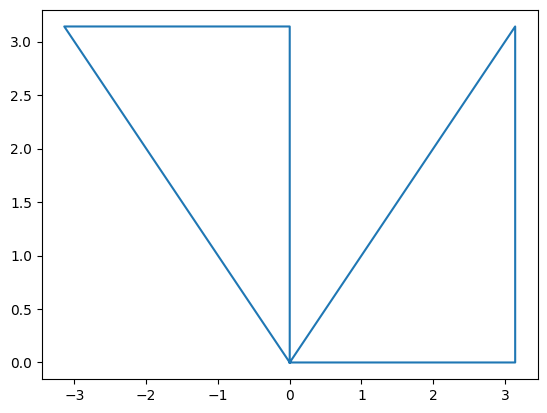

In [4]:
path = [("Γ", "Y"), ("Y", "M'"), ("M'", "Σ'"), ("Σ'","Γ"), ("Γ", "Σ"), ("Σ", "M"), ("M", "X"), ("X", "Γ")]
k_path, label, label_loc, distances = gen_kpath(k_points, path)
k_path = np.array(k_path)
plt.plot(k_path[:,0],k_path[:,1])

## ハミルトニアンの定義

In [7]:
def Hamiltonian(kx, ky):
    ta = -0.207
    tb = -0.067
    tp = -0.102
    tq = 0.043
    H = np.zeros((4,4), dtype=np.complex128)
    H[0,1] = ta + tb*np.exp(1j*kx)
    H[0,2] = tq * (1 + np.exp(-1j*ky))
    H[0,3] = tp * np.exp(-1j*ky) * (1 + np.exp(-1j*kx))

    H[1,2] = tp * (1 + np.exp(-1j*kx))
    H[1,3] = tq * np.exp(-1j*kx) * (1 + np.exp(-1j*ky))

    H[2,3] = ta + tb*np.exp(-1j*kx)

    for i in range(1,4):
        for j in range(0, i):
            H[i][j] = H[j][i].conjugate()

    return np.linalg.eigh(H)[0]


## バンドの計算

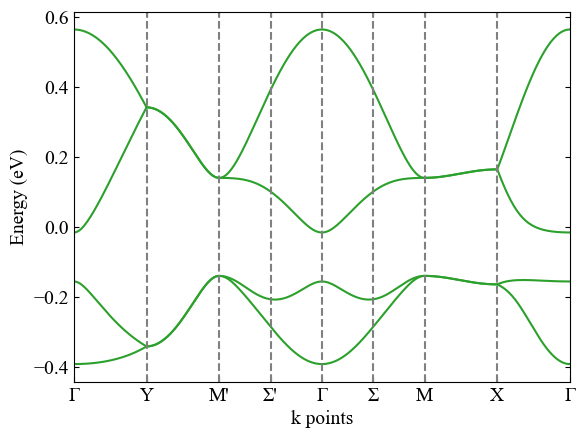

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# ax.set_aspect(5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

ax.set_xlabel("k points")
ax.set_ylabel("Energy (eV)")

Ymin = np.min(bands)-0.05
Ymax = np.max(bands)+0.05
ax.set_xticks(label_loc, label)
ax.set_xlim(label_loc[0], label_loc[-1])
ax.set_ylim(Ymin, Ymax)

ax.plot(distances, bands, color = "tab:green")
ax.vlines(label_loc[1:-1], Ymin,Ymax, "grey", "dashed")

plt.show()

参考 https://qiita.com/okumakito/items/3b2ccc9966c43a5e84d0

## フェルミ準位と状態密度

In [48]:
def DensityOfState(E, enes, sigma2 = 0.0001):
    dos = []
    for e in E:
        dos.append(np.sum(np.exp(-(e-enes)**2 / 2 / sigma2 ) / np.sqrt(2 * np.pi * sigma2)))
    dos = np.array(dos)
    dos /= np.sum(dos)
    return dos

In [11]:
N = 20
kx = np.linspace(-np.pi, np.pi, N)
ky = np.linspace(-np.pi, np.pi, N)
kx, ky = np.meshgrid(kx, ky)
enes = np.zeros((N, N, 4))
for i in range(N):
    for j in range(N):
        enes[i][j] = Hamiltonian(kx[i][j],ky[i][j])

In [32]:
sorted_enes = np.sort(enes[:,:,].flatten())
ef = sorted_enes[N*N*3]

0.20394571511995213


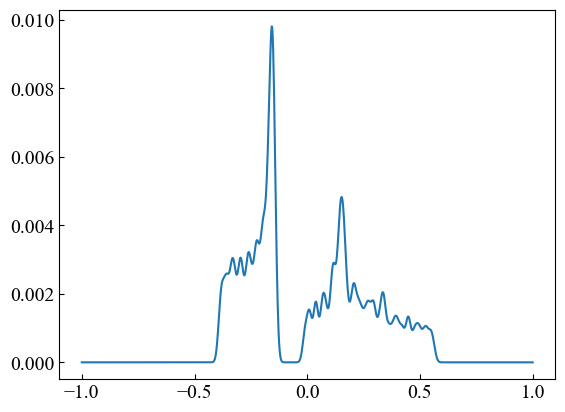

In [49]:
E = np.linspace(-1, 1, 1000)
dos = DensityOfState(E, sorted_enes)
plt.plot(E, dos)

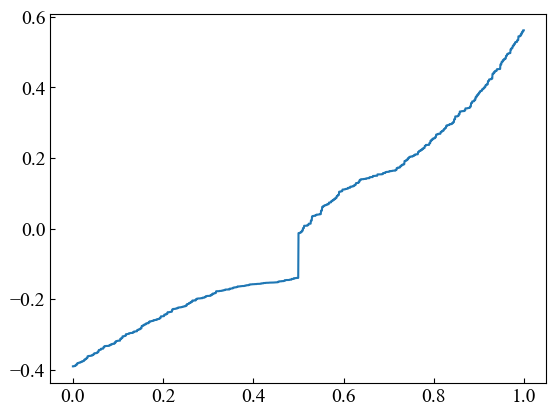

In [39]:
plt.plot(np.array(list(range(4*N*N)))/(4*N*N), np.sort(enes[:,:,].flatten()))

## バンド図

In [ ]:
bands = []
# plt.xticks(label)
for kxy in k_path:
    bands.append(Hamiltonian(kxy[0], kxy[1]))
bands = np.array(bands)

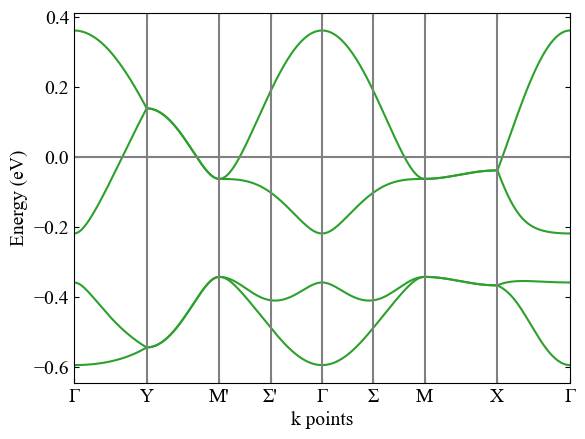

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# ax.set_aspect(5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

ax.set_xlabel("k points")
ax.set_ylabel("Energy (eV)")


Ymin = np.min(bands)-0.05 - ef
Ymax = np.max(bands)+0.05 - ef
ax.set_xticks(label_loc, label)
ax.set_xlim(label_loc[0], label_loc[-1])
ax.set_ylim(Ymin, Ymax)

ax.plot(distances, bands-ef, color = "tab:green")
ax.vlines(label_loc[1:-1], Ymin,Ymax, "grey", "solid")
ax.hlines(0, distances[0], distances[-1], "grey")

plt.show()

### 3D プロット

In [55]:
fig = go.Figure()

contours = dict(
    x=dict(highlight=False, show=True, color='grey', start=-3.5, end=3.5, size=0.5),
    y=dict(highlight=False, show=True, color='grey', start=-3.5, end=3.5, size=0.5),
    z=dict(highlight=False, show=False, start=-1, end = 1, size=0.5)
)

fig.add_trace(go.Surface(
        z=enes[:,:,0]-ef,
        x=kx,
        y=ky,
        colorscale = "jet",
        cmin=-0.6,
        cmax=0.4,
        # showscale = False,
        hoverinfo="skip",
        opacity=0.5,
        # hidesurface=True,
    )
)
for i in range(1, 4):
    fig.add_trace(go.Surface(
            z=enes[:,:,i]-ef,
            x=kx,
            y=ky,
            colorscale = "jet",
            cmin=-0.6,
            cmax=0.4,
            showscale = False,
            hoverinfo="skip",
            contours=contours,
            opacity=0.5,
            # hidesurface=True,
        )
    )
fig.add_trace(go.Surface(
        z=np.zeros((N,N)),
        x=kx,
        y=ky,
        colorscale = "jet",
        cmin=-0.6,
        cmax=0.4,
        # showscale = False,
        hoverinfo="skip",
        opacity=0.5,
        # hidesurface=True,
    )
)

axis = dict(visible=True)
fig.update_scenes(
    xaxis=axis,
    yaxis=axis,
    zaxis=axis,
    aspectratio=dict(x=1,y=1,z=1.5)
)
fig.update_layout(
    width=800,   # グラフの幅
    height=800   # グラフの高さ
)
fig.show()